In [1]:
#----------------------------------------------------
#-- KMeans Clustering
#-- Number of Clusters and Key-frames are fixed
#----------------------------------------------------

In [2]:
#-- Import Libreries -----------------------------------------------------------------------------
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#--------------------------------------------------------------------------------------------------

In [15]:
#-- Initialize -------------------------------------------------------------------------------------
output_path = '/kaggle/working/'

burglary_zip_file_path = '/kaggle/input/novin-smart-dropping-kmeans-preprocess-resnet50/burglary_samples.zip'
burglary_unzip_folder = output_path + 'burglary_samples/'

not_burglary_zip_file_path = '/kaggle/input/novin-smart-dropping-kmeans-preprocess-resnet50/not_burglary_samples.zip'
not_burglary_unzip_folder = output_path + 'not_burglary_samples/'

charts_folder = output_path + 'charts/'

key_frames_burglary_dir = output_path + 'key_frames_burglary_samples/'
key_frames_not_burglary_dir = output_path + 'key_frames_not_burglary_samples/'

NUM_CLUSTERS = 32
#---------------------------------------------------------------------------------------------------

In [10]:
#-- Extract Features -------------------------------------------------------------------------------
with zipfile.ZipFile(burglary_zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(burglary_unzip_folder)

with zipfile.ZipFile(not_burglary_zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(not_burglary_unzip_folder)
#---------------------------------------------------------------------------------------------------

In [16]:
#-- Create output Folders --------------------------------------------------------------------------
os.makedirs(charts_folder, exist_ok=True)
os.makedirs(key_frames_burglary_dir, exist_ok=True)
os.makedirs(key_frames_not_burglary_dir, exist_ok=True)
#---------------------------------------------------------------------------------------------------

In [18]:
#-- Function to Plot Elbow and Silhouette ---------------------------------------------------------
def plot_elbow(features, file_name, max_clusters=NUM_CLUSTERS):
    distortions = []
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(features)
        distortions.append(kmeans.inertia_)  
        silhouette_scores.append(silhouette_score(features, kmeans.labels_))

    #-- Elbow --
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal K')   

    #-- Silhouette --
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal K')

    output_file = os.path.join(charts_folder, f"{file_name}_charts.png")
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()
    plt.close()      
#---------------------------------------------------------------------------------------------------

In [20]:
#-- Function to Select Key Frames: Closest Frame to Center of Cluster ------------------------------
def select_key_frames(features, num_clusters, output_path):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(features)
    key_frame_indices = []

    for cluster in range(num_clusters):        
        cluster_center = kmeans.cluster_centers_[cluster]
        distances = np.linalg.norm(features - cluster_center, axis=1)
        key_frame_index = np.argmin(distances)
        key_frame_indices.append(key_frame_index)
    
    np.save(output_path, np.array(key_frame_indices))
    print(f"Key frames saved to {output_path}")

    return key_frame_indices
#---------------------------------------------------------------------------------------------------

In [23]:
#-- Function to Run Process ------------------------------------------------------------------------
def cluster_and_select_key_frames(features_dir, output_dir):

    feature_files = [f for f in os.listdir(features_dir) if f.endswith('.npy')]
    feature_files.sort()

    for feature_file in feature_files:    
        video_name = feature_file.split('.')[0]  
        video_name = video_name.split('_features')[0]
        feature_path = os.path.join(features_dir, feature_file)
        output_path = os.path.join(output_dir, f"{video_name}_keyframes.npy")    
       
        features = np.load(feature_path)
        num_frames = features.shape[0]          
        
        print(f"Processing {video_name} with {num_frames} frames .............................")        
        
        plot_elbow(features, video_name, NUM_CLUSTERS)    
        
        key_frames = select_key_frames(features, NUM_CLUSTERS, output_path)
        print(f"Key frames for {video_name}: {key_frames}")
        
#---------------------------------------------------------------------------------------------------

Processing burglary_10 with 1085 frames .............................


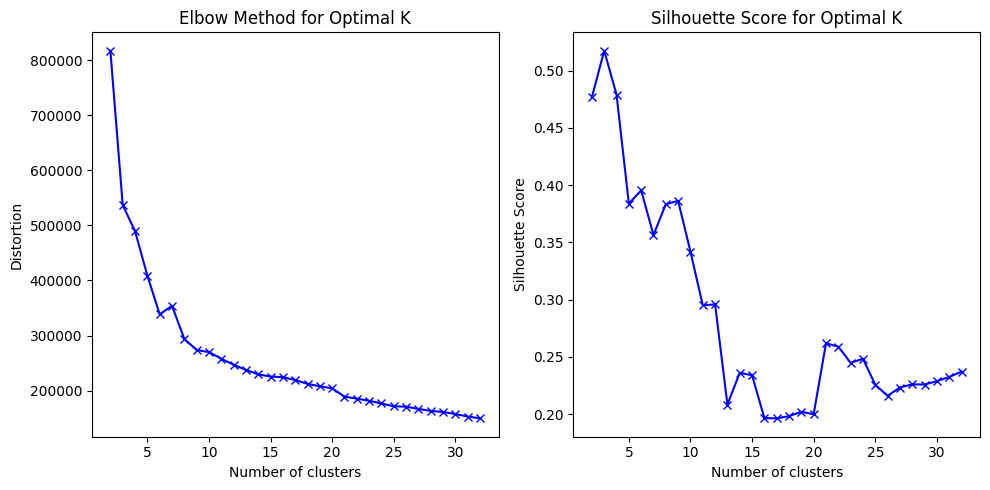

Key frames saved to /kaggle/working/key_frames_burglary_samples/burglary_10_keyframes.npy
Key frames for burglary_10: [703, 351, 24, 159, 1055, 906, 414, 99, 432, 785, 124, 1007, 385, 998, 645, 41, 873, 984, 62, 950, 515, 889, 311, 80, 244, 174, 202, 967, 14, 139, 942, 990]
Processing not_burglary_10 with 2423 frames .............................


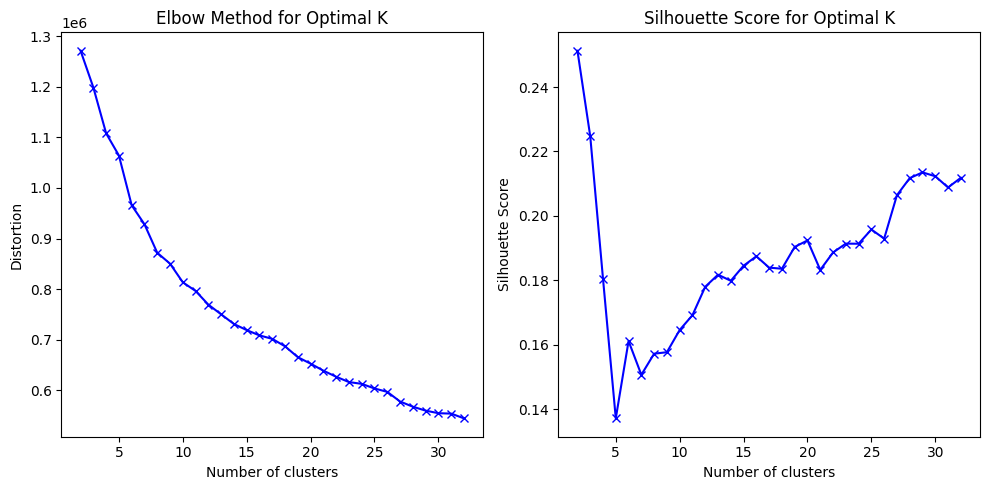

Key frames saved to /kaggle/working/key_frames_not_burglary_samples/not_burglary_10_keyframes.npy
Key frames for not_burglary_10: [1643, 562, 50, 1598, 445, 1450, 1197, 880, 1044, 1739, 853, 2312, 1083, 1953, 2163, 332, 1293, 687, 832, 2104, 508, 1836, 2205, 1684, 774, 1513, 1793, 985, 2351, 2395, 2046, 212]


In [24]:
#-- Run  --------------------------------------------------------------------------------------------
cluster_and_select_key_frames(features_dir= burglary_unzip_folder,
                              output_dir= key_frames_burglary_dir)

cluster_and_select_key_frames(features_dir= not_burglary_unzip_folder,
                              output_dir= key_frames_not_burglary_dir)
#---------------------------------------------------------------------------------------------------